<a href="https://colab.research.google.com/github/franlin1860/llm/blob/main/insurance_react_agent_v040821.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow for a Insurance ReAct Agent

This notebook walks through setting up a `Workflow` to construct a ReAct agent from (mostly) scratch.

React calling agents work by prompting an LLM to either invoke tools/functions, or return a final response.

Our workflow will be stateful with memory, and will be able to call the LLM to select tools and process incoming user messages.

# 防断开

In [6]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button");
     btn.click()
     }

   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect");
     btn.click()
     }
  }

setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [ ]:
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);

In [3]:
!pip install -U llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfull

In [5]:
import os

os.environ["DEEPSEEK_API_KEY"] = "sk-"

# Set up LLM

In [4]:
!pip install llama_index-llms-openai_like
!pip install llama_index-embeddings-huggingface

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [7]:
import os
import logging
import sys
from llama_index.llms.openai_like import OpenAILike
from llama_index.core import Settings, ServiceContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# 配置日志
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# 定义DeepSpeed model
llm = OpenAILike(model="deepseek-chat",
                 api_base="https://api.deepseek.com/v1",
                 api_key=os.environ["DEEPSEEK_API_KEY"],
                 temperature=0.6,
                 is_chat_model=True)

# 配置环境
Settings.llm = llm

# 设置嵌入模型
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-zh-v1.5")
Settings.embed_model = embed_model
Settings.chunk_size = 256
service_context = ServiceContext.from_defaults(
    llm=llm, embed_model=embed_model
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-7-f86546c39a13>:25: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


Since workflows are async first, this all runs fine in a notebook. If you were running in your own code, you would want to use `asyncio.run()` to start an async event loop if one isn't already running.

```python
async def main():
    <async code>

if __name__ == "__main__":
    import asyncio
    asyncio.run(main())
```

## Designing the Workflow

An agent consists of several steps
1. Handling the latest incoming user message, including adding to memory and preparing the chat history
2. Using the chat history and tools to construct a ReAct prompt
3. Calling the llm with the react prompt, and parsing out function/tool calls
4. If no tool calls, we can return
5. If there are tool calls, we need to execute them, and then loop back for a fresh ReAct prompt using the latest tool calls

### The Workflow Events

To handle these steps, we need to define a few events:
1. An event to handle new messages and prepare the chat history
2. An event to prompt the LLM with the react prompt
3. An event to trigger tool calls, if any
4. An event to handle the results of tool calls, if any

The other steps will use the built-in `StartEvent` and `StopEvent` events.

In addition to events, we will also use the global context to store the current react reasoning!

In [8]:
from llama_index.core.workflow import Event

class StartConversationEvent(Event):
    message: str

class ServiceTypeEvent(Event):
    service_type: str

class InsuranceVerificationEvent(Event):
    insurance_number: str

class HospitalCheckEvent(Event):
    hospital_name: str

class DepositConfirmationEvent(Event):
    deposit_amount: float

class SystemAuditEvent(Event):
    is_approved: bool

class EndConversationEvent(Event):
    final_message: str

代码解释
run_insurance_workflow: 这个函数模拟了整个工作流的运行过程，从用户开始对话到系统返回最终审核结果。

StartEvent: 模拟用户的初始输入，例如 "我需要申请医疗垫付服务"。

new_user_msg: 处理用户输入并准备后续的步骤。

handle_service_type: 判断业务类型是否为医疗垫付，如果是，则继续进行下一步验证。

verify_insurance: 系统要求用户提供保单号，并进行验证。

handle_insurance_number: 用户输入保单号后，系统检查保单号的有效性，并要求用户输入医院名称。

handle_hospital_check: 系统检查医院是否符合条件。

confirm_deposit: 系统要求用户提供押金金额，并确认押金是否符合垫付条件。

audit_request: 系统对整个请求进行最终审核，并给出结果。

### The Workflow Itself

With our events defined, we can construct our workflow and steps.

Note that the workflow automatically validates itself using type annotations, so the type annotations on our steps are very helpful!

In [26]:
os.environ["INSURANCE_NUMBER"] = "123456789"

In [27]:
from typing import Any, List
from llama_index.core.agent.react import ReActChatFormatter, ReActOutputParser
from llama_index.core.llms import ChatMessage
from llama_index.core.agent.react.types import (
    ActionReasoningStep,
    ObservationReasoningStep,
)
from llama_index.core.llms.llm import LLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.tools.types import BaseTool
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)

class InsuranceReActAgent(Workflow):
    def __init__(
        self,
        *args: Any,
        llm: LLM | None = None,
        tools: list[BaseTool] | None = None,
        extra_context: str | None = None,
        **kwargs: Any,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.tools = tools or []
        self.llm = Settings.llm
        self.memory = ChatMemoryBuffer.from_defaults(llm=llm)
        self.formatter = ReActChatFormatter(context=extra_context or "")
        self.output_parser = ReActOutputParser()
        self.sources = []

    @step(pass_context=True)
    async def new_user_msg(self, ctx: Context, ev: StartEvent) -> StartConversationEvent:
        # 清理 sources
        self.sources = []

        # 获取用户输入
        user_input = ev.input
        user_msg = ChatMessage(role="user", content=user_input)
        self.memory.put(user_msg)

        # 清理当前推理过程
        ctx.data["current_reasoning"] = []

        # Provide the required 'message' field
        return StartConversationEvent(message=user_input) # Pass the user input as the message

    @step(pass_context=True)
    async def handle_service_type(self, ctx: Context, ev: StartConversationEvent) -> ServiceTypeEvent | StopEvent:
        # 处理用户输入，判断业务类型
        user_input = self.memory.get()[-1].content
        print(f"用户输入: {user_input}")

        if "医疗垫付" in user_input:
            return ServiceTypeEvent(service_type="医疗垫付")
        else:
            return StopEvent(result="目前只能处理医疗垫付服务的请求。")

    @step(pass_context=True)
    async def verify_insurance(self, ctx: Context, ev: ServiceTypeEvent) -> InsuranceVerificationEvent | StopEvent:
        if ev.service_type == "医疗垫付":
            # 1. 输出提示用户输入保单号
            print("请输入您的保单号：")

            # 2. 提供输入框，等待客户输入
            customer_input = input()

            # 3. 将客户输入转化为保单号
            # (这里你可以添加一些校验逻辑，确保输入符合保单号格式)
            insurance_number = customer_input.strip()

            # 4. 对保单进行处理
            if insurance_number:
                # ... 这里你可以添加处理保单号的逻辑 ...
                return InsuranceVerificationEvent(insurance_number=insurance_number)
            else:
                return StopEvent(result="未输入保单号。")
        else:
            return StopEvent(result="业务类型不支持。")

    @step(pass_context=True)
    async def handle_insurance_number(self, ctx: Context, ev: InsuranceVerificationEvent) -> HospitalCheckEvent | StopEvent:
        # 假设用户输入了保单号，这里是一个模拟的步骤
        insurance_number = ev.insurance_number or self.memory.get()[-1].content
        if insurance_number.isdigit():
            return HospitalCheckEvent(hospital_name="北大医院")
        else:
            return StopEvent(result="无效的保单号，请重新输入。")

    @step(pass_context=True)
    async def handle_insurance_number(self, ctx: Context, ev: InsuranceVerificationEvent) -> HospitalCheckEvent | StopEvent:
        # 1. 给用户提示
        print("根据您的保单，您可以申请医疗垫付服务。请问您已经住院了吗？如果是，请提供住院医院的名称。")

        # 2. 让用户输入住院的医院名称
        hospital_name = input()

        # 3. 得到医院名称
        if hospital_name:
            return HospitalCheckEvent(hospital_name=hospital_name)
        else:
            return StopEvent(result="未提供住院医院名称。")

    @step(pass_context=True)
    async def handle_hospital_check(self, ctx: Context, ev: HospitalCheckEvent) -> DepositConfirmationEvent | StopEvent:
        # 获取医院名称
        hospital_name = ev.hospital_name or self.memory.get()[-1].content

        # 1. 给用户提示
        print(f"感谢提供信息。{hospital_name}符合医疗垫付服务的医院要求。请问您已经支付了住院押金吗？如果是，请提供押金金额。")

        # 2. 让用户进行输入
        deposit_amount = input()

        # 3. 得到用户住院押金金额
        if deposit_amount:
            try:
                # 尝试将输入转换为数字
                deposit_amount = float(deposit_amount)
                return DepositConfirmationEvent(deposit_amount=deposit_amount)
            except ValueError:
                return StopEvent(result="请输入有效的押金金额。")
        else:
            return StopEvent(result="未提供住院押金金额。")

    @step(pass_context=True)
    async def confirm_deposit(self, ctx: Context, ev: DepositConfirmationEvent) -> SystemAuditEvent | StopEvent:
        # 假设用户输入了押金金额，这里是一个模拟的步骤
        deposit_amount = ev.deposit_amount or float(self.memory.get()[-1].content)
        if deposit_amount >= 10000:
            return SystemAuditEvent(is_approved=True)
        else:
            return StopEvent(result="押金金额不足，无法申请垫付服务。")

    @step(pass_context=True)
    async def audit_request(self, ctx: Context, ev: SystemAuditEvent) -> StopEvent:
        # 最终审核并给出结果
        print("好的，您的住院押金符合垫付申请条件。我需要查询系统进一步确认信息。")
        if ev.is_approved:
            final_message = "您的申请已通过初步审核，我们将在1-2个工作日内完成最终审核并通知您垫付金额和后续步骤。"
        else:
            final_message = "您的申请未通过审核。"
        return StopEvent(result=final_message)


And thats it! Let's explore the workflow we wrote a bit.

代码解释

new_user_msg: 处理用户的初始消息并清理之前的推理数据。

handle_service_type: 根据用户的输入判断业务类型，如果匹配“医疗垫付”，则继续流程。

verify_insurance: 要求用户输入保单号，并检查其有效性。

handle_insurance_number: 验证保单号是否有效，并准备检查医院信息。

handle_hospital_check: 检查用户输入的医院是否在服务范围内。

confirm_deposit: 确认用户的押金金额是否符合条件。

audit_request: 对申请进行最终审核，并向用户反馈审核结果。

## Run the Workflow!

**NOTE:** With loops, we need to be mindful of runtime. Here, we set a timeout of 120s.

In [28]:
# 创建 ReActAgent 实例
agent = InsuranceReActAgent(timeout=180, verbose=True)

ret = await agent.run(input="我需要申请医疗垫付服务")

Running step new_user_msg
Step new_user_msg produced event StartConversationEvent
Running step handle_service_type
用户输入: 我需要申请医疗垫付服务
Step handle_service_type produced event ServiceTypeEvent
Running step verify_insurance
请输入您的保单号：
1234567
Step verify_insurance produced event InsuranceVerificationEvent
Running step handle_insurance_number
根据您的保单，您可以申请医疗垫付服务。请问您已经住院了吗？如果是，请提供住院医院的名称。
 北大医院
Step handle_insurance_number produced event HospitalCheckEvent
Running step handle_hospital_check
感谢提供信息。 北大医院符合医疗垫付服务的医院要求。请问您已经支付了住院押金吗？如果是，请提供押金金额。
20000
Step handle_hospital_check produced event DepositConfirmationEvent
Running step confirm_deposit
Step confirm_deposit produced event SystemAuditEvent
Running step audit_request
好的，您的住院押金符合垫付申请条件。我需要查询系统进一步确认信息。
Step audit_request produced event StopEvent


In [29]:
print(str(ret))

您的申请已通过初步审核，我们将在1-2个工作日内完成最终审核并通知您垫付金额和后续步骤。


# Show workflow

In [31]:
!pip install pyvis

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [32]:
from llama_index.core.workflow import draw_all_possible_flows

draw_all_possible_flows(InsuranceReActAgent, filename="insurance_react_agent.html")

<ipython-input-32-517d6d1f1d76>:3: DeprecationWarning: Call to deprecated function (or staticmethod) draw_all_possible_flows. (Install `llama-index-utils-workflow` and use the import `from llama_index.utils.workflow` instead.)
  draw_all_possible_flows(InsuranceReActAgent, filename="insurance_react_agent.html")


insurance_react_agent.html


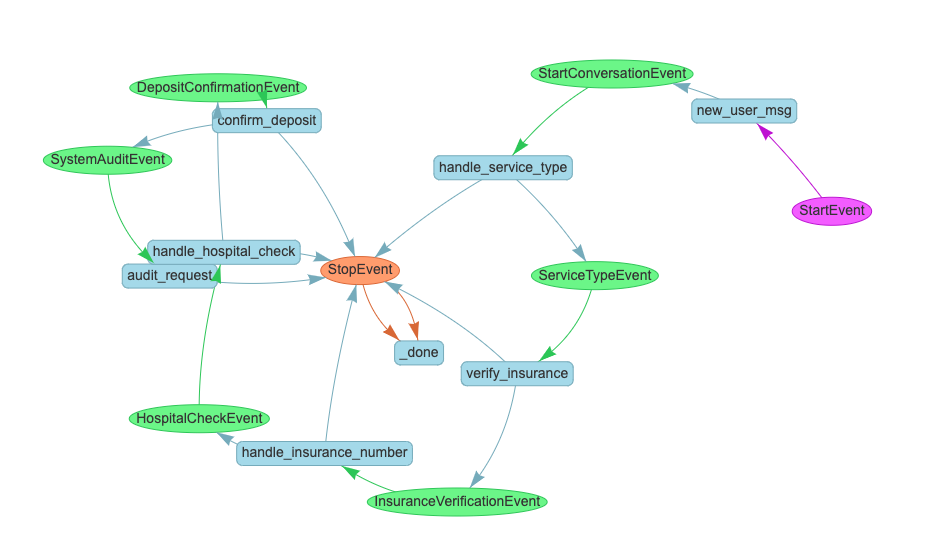